In [ ]:
#!pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: astropy
    Found existing installation: astropy 4.3.1
    Uninstalling astropy-4.3.1:
      Successfully uninstalled astropy-4.3.1


#Correspondance des PSFs (MATCHING PSFs)
Nous utilisons ici le paquet photutils pour générer des noyaux permettant de faire correspondre les fonctions d'étalement du point (PSFs).

Pour ces gaussiennes 2D, le noyau de correspondance devrait être une gaussienne 2D avec $\sigma=4=\sqrt{(5^2 - 3^2)}$. Créons le noyau d'adaptation en utilisant une méthode de rapport de Fourier. Notez que les PSF source et cible d'entrée doivent avoir la même forme et la même échelle de pixels :

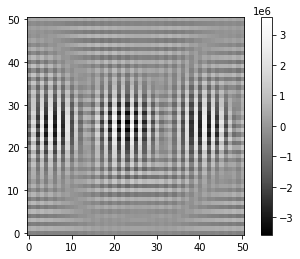

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Gaussian2D
from photutils.psf import create_matching_kernel

#creating the “high-resolution” PSF will be a Gaussian with sigma being equal to 3. The “low-resolution” PSF will be a Gaussian with sigma being equal to 5.

y, x = np.mgrid[0:51, 0:51]
gm1 = Gaussian2D(100, 25, 25, 3, 3)
gm2 = Gaussian2D(100, 25, 25, 5, 5)
g1 = gm1(x, y)
g2 = gm2(x, y)
g1 /= g1.sum()
g2 /= g2.sum()

kernel = create_matching_kernel(g1, g2)
plt.imshow(kernel, cmap='Greys_r', origin='lower')
plt.colorbar()

Ce n'est pas le résultat souhaité. Avant de poursuivre, nous remarquons que Photutils fournit certaines fonctions de fenêtre pour filtrer le bruit à haute fréquence des rapports de Fourier:

(0.0, 1.1)

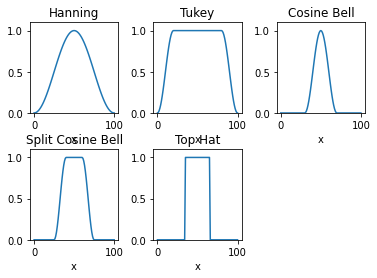

In [ ]:
import matplotlib.pyplot as plt
from photutils.psf import (CosineBellWindow, HanningWindow,
                           SplitCosineBellWindow, TopHatWindow,
                           TukeyWindow)

window1 = HanningWindow()
window2 = TukeyWindow(alpha=0.4)
window3 = CosineBellWindow(alpha=0.4)
window4 = SplitCosineBellWindow(alpha=0.3, beta=0.2)
window5 = TopHatWindow(beta=0.3)
shape = (101, 101)
y0 = (shape[0] - 1) // 2

plt.figure()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 3, 1)
plt.plot(window1(shape)[y0, :])
plt.title('Hanning')
plt.xlabel('x')
plt.ylim((0, 1.1))

plt.subplot(2, 3, 2)
plt.plot(window2(shape)[y0, :])
plt.title('Tukey')
plt.xlabel('x')
plt.ylim((0, 1.1))

plt.subplot(2, 3, 3)
plt.plot(window3(shape)[y0, :])
plt.title('Cosine Bell')
plt.xlabel('x')
plt.ylim((0, 1.1))

plt.subplot(2, 3, 4)
plt.plot(window4(shape)[y0, :])
plt.title('Split Cosine Bell')
plt.xlabel('x')
plt.ylim((0, 1.1))

plt.subplot(2, 3, 5)
plt.plot(window5(shape)[y0, :], label='Top Hat')
plt.title('Top Hat')
plt.xlabel('x')
plt.ylim((0, 1.1))

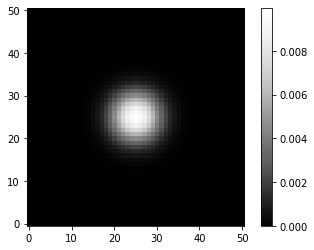

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Gaussian2D
from photutils.psf import TopHatWindow, create_matching_kernel

y, x = np.mgrid[0:51, 0:51]
gm1 = Gaussian2D(100, 25, 25, 3, 3)
gm2 = Gaussian2D(100, 25, 25, 5, 5)
g1 = gm1(x, y)
g2 = gm2(x, y)
g1 /= g1.sum()
g2 /= g2.sum()

window = TopHatWindow(0.40)
kernel = create_matching_kernel(g1, g2, window=window)
plt.imshow(kernel, cmap='Greys_r', origin='lower')
plt.colorbar()

Comme souhaité, le résultat est maintenant, en effet, une gaussienne 2D avec un $\sigma=4$. Ici, des coupes 1D à travers le centre des images du noyau sont illustrées :

(0.0, 0.011)

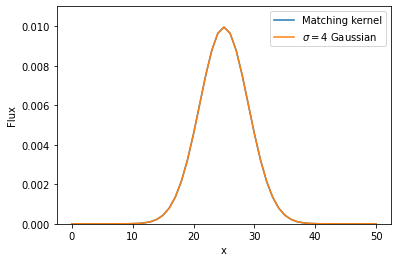

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Gaussian2D
from photutils.psf import TopHatWindow, create_matching_kernel

y, x = np.mgrid[0:51, 0:51]
gm1 = Gaussian2D(100, 25, 25, 3, 3)
gm2 = Gaussian2D(100, 25, 25, 5, 5)
gm3 = Gaussian2D(100, 25, 25, 4, 4)
g1 = gm1(x, y)
g2 = gm2(x, y)
g3 = gm3(x, y)
g1 /= g1.sum()
g2 /= g2.sum()
g3 /= g3.sum()

window = TopHatWindow(0.40)
kernel = create_matching_kernel(g1, g2, window=window)
kernel /= kernel.sum()
plt.plot(kernel[25, :], label='Matching kernel')
plt.plot(g3[25, :], label='$\\sigma=4$ Gaussian')
plt.xlabel('x')
plt.ylabel('Flux')
plt.legend()
plt.ylim((0.0, 0.011))

Comme nous l'avons montré, le noyau d'adaptation (matching kernel) est parfaitement adapté à la gaussienne avec $\sigma=4$

#UN EXEMPLE PLUS SOPHISTIQUÉ

Pour donner un exemple, générons un noyau de correspondance pour passer du PSF du canal 1 (3,6 microns) de Spitzer/IRAC au PSF du canal 4 (8,0 microns). Nous chargeons les PSFs en utilisant la fonction load_irac_psf().

Montrons les images:


Text(0.5, 1.0, 'IRAC channel 4 PSF')

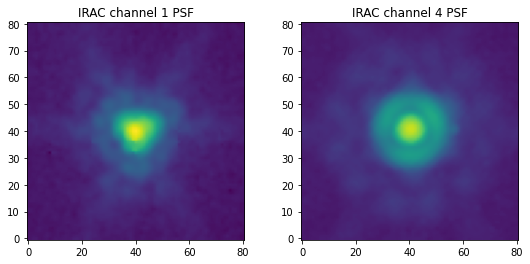

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.datasets import load_irac_psf

channel1_hdu = load_irac_psf(channel=1)
channel4_hdu = load_irac_psf(channel=4)

psf_de_ch1 = channel1_hdu.data
psf_de_ch4 = channel4_hdu.data
norm = ImageNormalize(stretch=LogStretch())

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(ch1, norm=norm, cmap='viridis', origin='lower')
plt.title('IRAC channel 1 PSF')

plt.subplot(1, 2, 2)
plt.imshow(ch4, norm=norm, cmap='viridis', origin='lower')
plt.title('IRAC channel 4 PSF')

Pour cet exemple, nous utiliserons la fenêtre CosineBellWindow pour la fenêtre passe-bas. Notez que ces PSFs Spitzer/IRAC canal 1 et 4 ont la même forme et la même échelle de pixels. Si ce n'est pas le cas, on peut utiliser la fonction pratique resize_psf() pour redimensionner une image PSF. Typiquement, on interpole le PSF de plus basse résolution à la même taille que le PSF de plus haute résolution.

In [ ]:
from photutils.psf import CosineBellWindow, create_matching_kernel

window = CosineBellWindow(alpha=0.40)
kernel = create_matching_kernel(ch1, ch4, window=window)

Affichons les noyaux correspondants:

Text(0.5, 1.0, 'Matching kernel')

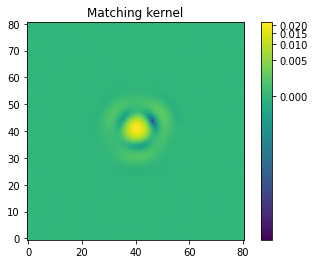

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.datasets import load_irac_psf
from photutils.psf import CosineBellWindow, create_matching_kernel

channel1_hdu = load_irac_psf(channel=1)
channel4_hdu = load_irac_psf(channel=4)

psf_de_ch1 = channel1_hdu.data
psf_de_ch4 = channel4_hdu.data
norm = ImageNormalize(stretch=LogStretch())

window = CosineBellWindow(alpha=0.40)
kernel = create_matching_kernel(ch1, ch4, window=window)

plt.imshow(kernel, norm=norm, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Matching kernel')